Clustering analysis

In [325]:
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [326]:
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Combined_data_new.csv'
df=pd.read_csv(url,index_col='FIPS',encoding="ISO-8859-1")

In [327]:
#standardize data: (x-mean(x))/std
from sklearn import preprocessing
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 1001 to 56045
Data columns (total 61 columns):
var57                                0 non-null float64
var68                                3139 non-null float64
var44                                3137 non-null float64
var60                                3143 non-null float64
var14                                3143 non-null float64
var13                                3124 non-null float64
var39                                3143 non-null float64
var9                                 3124 non-null float64
var67                                3139 non-null float64
var3                                 3140 non-null float64
var40                                3143 non-null float64
var23                                3143 non-null float64
var8                                 3124 non-null float64
var18                                3141 non-null float64
var2                                 3123 non-null float64
var65  

In [334]:
#read in variable information and build variable information dictionary with variable names as key
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Food_atlas/Var_name_info.csv'
var_info_df=pd.read_csv(url,encoding="ISO-8859-1", index_col='var_name')

In [335]:
df_no_region=df[df.columns.difference(['Region', 'Division','State', 'County', 'RUCC_2013'])]

In [336]:
df_dropnacol=df_no_region.dropna(axis=1)

In [337]:
df_dropnacol.shape

(3143, 31)

build pipeline for hierachical clustering: scaler to clustering

In [338]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(df_dropnacol.values)
normed_df=pd.DataFrame(X_minmax, index=df_dropnacol.index, columns=df_dropnacol.columns)

#normed_data=preprocessing.scale(df_dropnacol)
#normed_df=pd.DataFrame(normed_data, index=df_dropnacol.index, columns=df_dropnacol.columns)

PCA

In [339]:
#PCA using Sklearn 
from sklearn.decomposition import PCA

explained_var=list()
for d in range(1,len(normed_df.columns)):
    pca = PCA(n_components=d)
    pca.fit(normed_df)
    explained_var.append(sum(pca.explained_variance_ratio_))

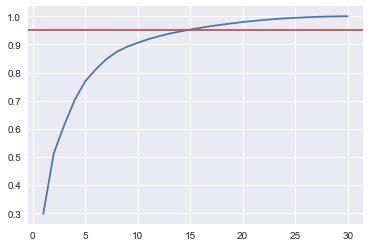

In [340]:
plt.plot(range(1,len(normed_df.columns)), explained_var)
plt.axhline(y=0.95, color='r')
plt.show()

In [341]:
#95% of variance can be explained by 15 components out of total 31 variables
pca = PCA(n_components=15)
pca.fit(normed_df)

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [342]:
data_transformed=pca.transform(normed_df)
df_transformed=pd.DataFrame(data_transformed, index=normed_df.index)

Hierachical clustering

In [343]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

X=df_transformed
distance_way= ['ward', 'single', 'average', 'weighted', 'centroid', 'median']

for m in distance_way:
    Z = linkage(X, m)
    c, coph_dists = cophenet(Z, pdist(X))
    print (m, c)

ward 0.64410981489
single 0.694510687386
average 0.762436572495
weighted 0.679177902855
centroid 0.73066289083
median 0.628616714824


both average method and centroid method is the best regarding the similarity between compuated distance to real distance

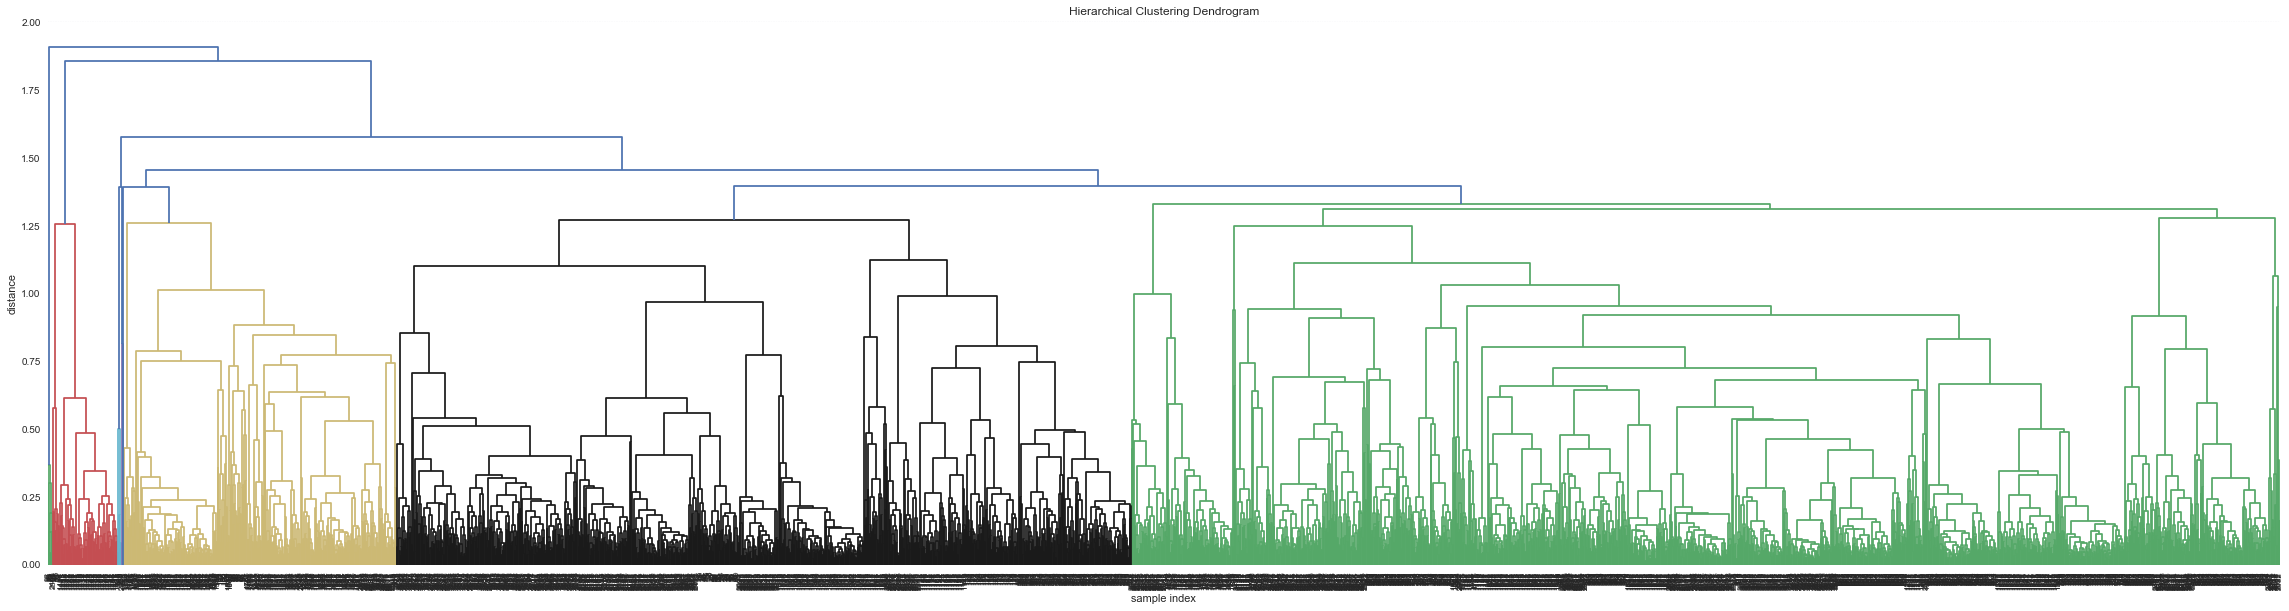

In [344]:
Z = linkage(X, 'average')
plt.figure(figsize=(40, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.show()

cut into several clusters to better understand each cluster

In [345]:
from scipy.cluster.hierarchy import cut_tree, fcluster
from collections import Counter

for distance in np.linspace(1, 1.5, 6):
    labels = fcluster(Z,distance,'distance')
    print (distance, max(Counter(labels).values()), max(labels))

1.0 933 21
1.1 1003 18
1.2 1251 15
1.3 1255 10
1.4 2652 5
1.5 3037 4


In [346]:
labels = fcluster(Z,1.3,'distance')
Counter(labels)

Counter({1: 7,
         2: 92,
         3: 5,
         4: 2,
         5: 384,
         6: 1,
         7: 1035,
         8: 143,
         9: 1255,
         10: 219})

In [347]:
groups_to_plot=[l for l in Counter(labels).keys() if Counter(labels)[l]>10]

In [348]:
groups_to_plot

[7, 2, 5, 9, 10, 8]

In [349]:
sum([v for v in Counter(labels).values() if v>=10])

3128

In [350]:
df['group']=labels

In [358]:
def Box_plot_by_var(features, data, by):
    n=1
    for c in features:
        if is_numeric_dtype(data[c]):
            sns.boxplot(x=by, y=c, data=data)
            if c in var_info_df.index:
                plt.ylabel(str(var_info_df.loc[c]['Category Name'])+'\n'+str(var_info_df.loc[c]['Sub_subcategory Name']))            
            else: 
                plt.ylabel(c)
            plt.title(c)
            plt.legend()
            plt.show()
            n+=1

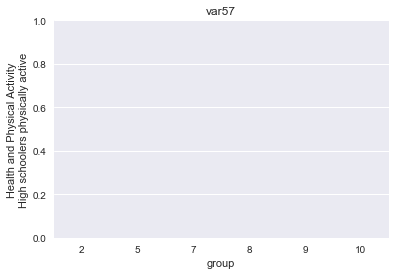

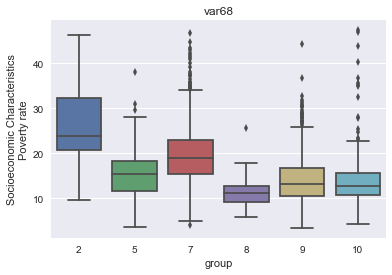

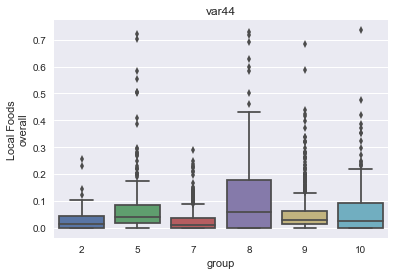

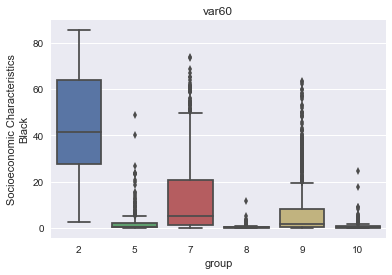

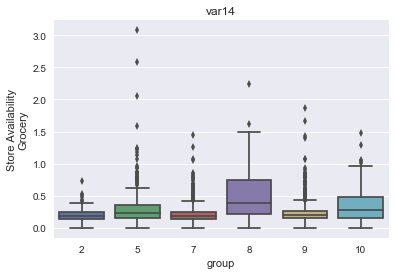

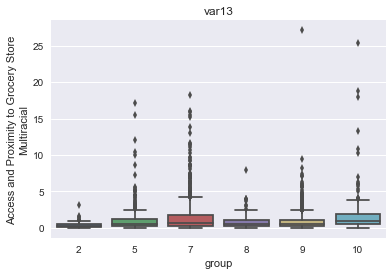

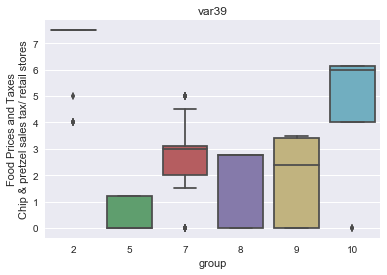

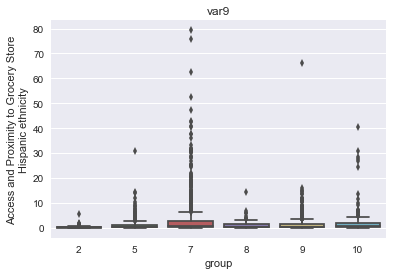

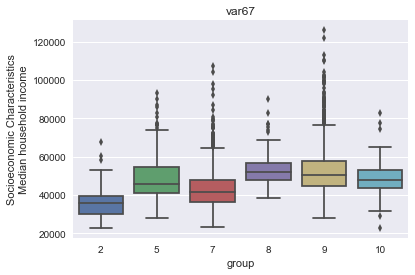

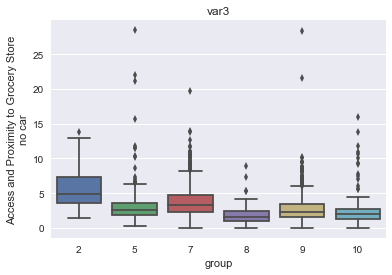

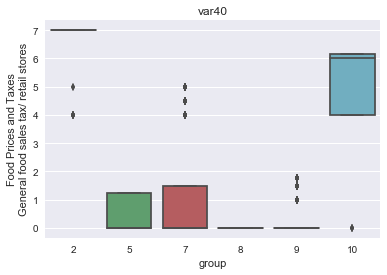

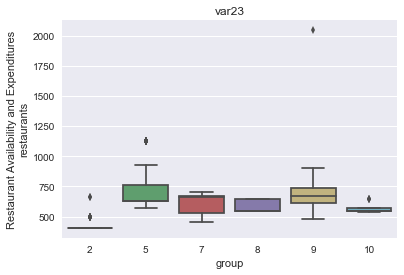

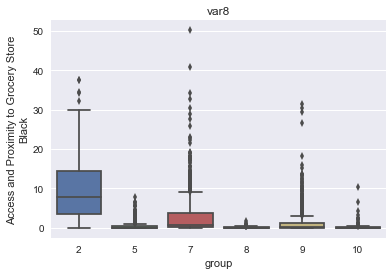

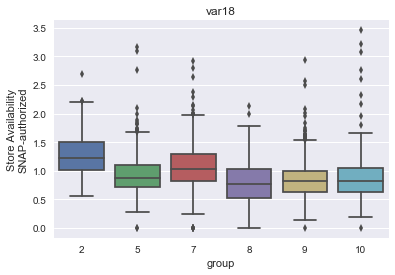

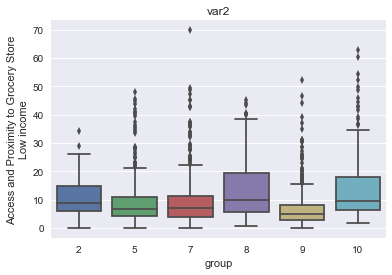

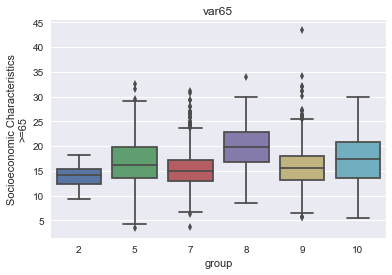

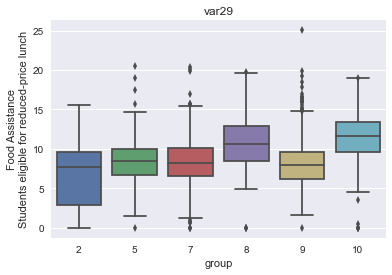

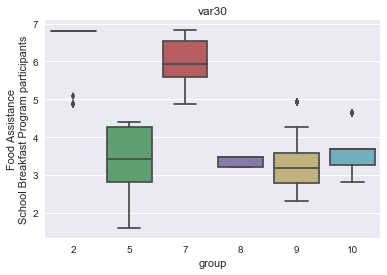

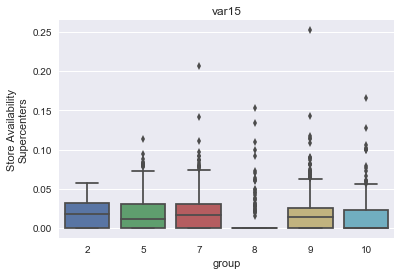

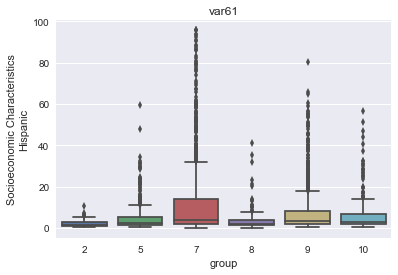

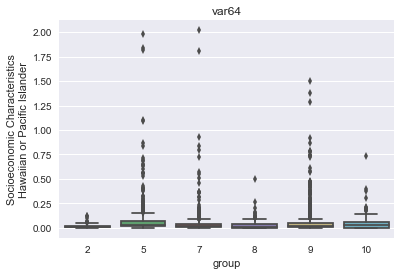

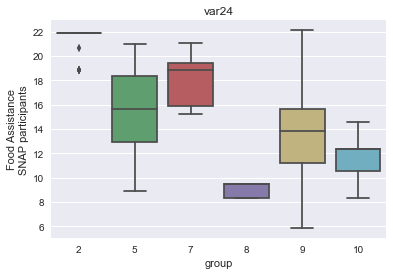

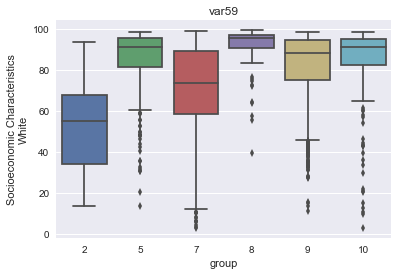

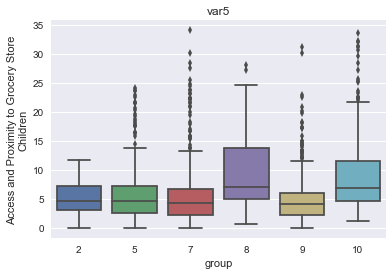

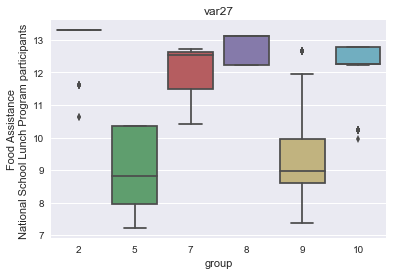

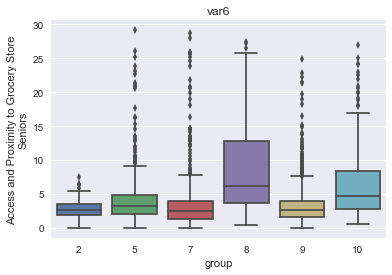

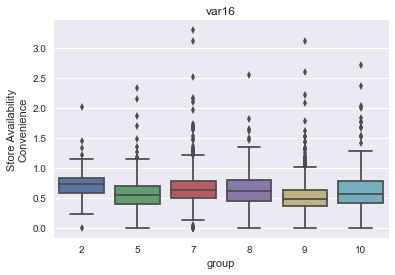

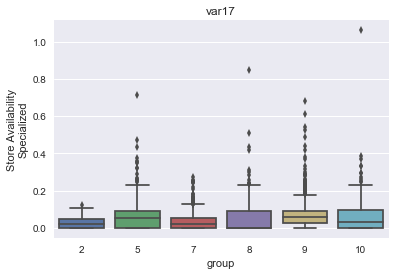

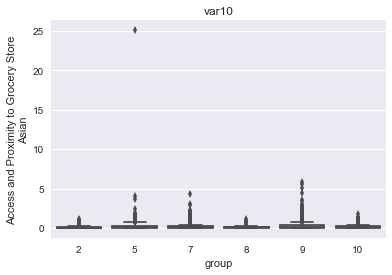

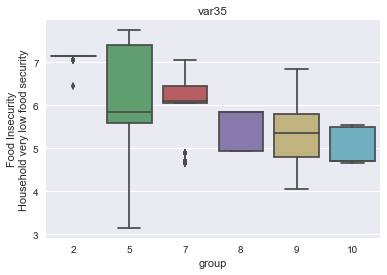

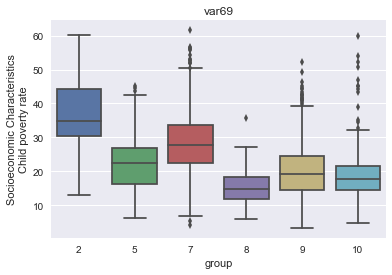

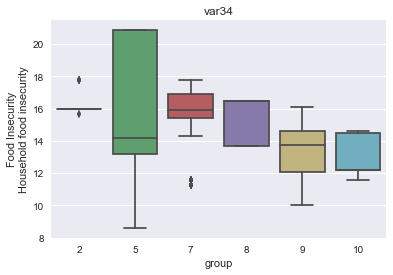

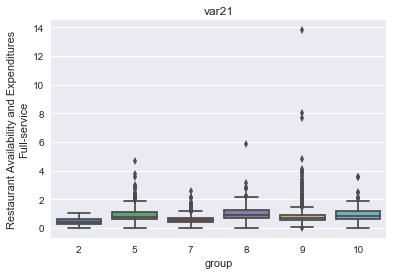

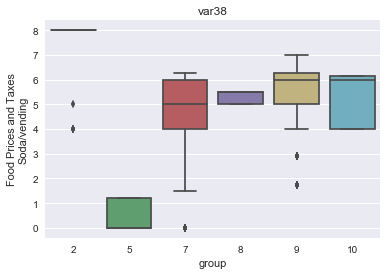

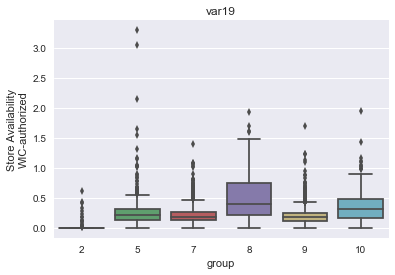

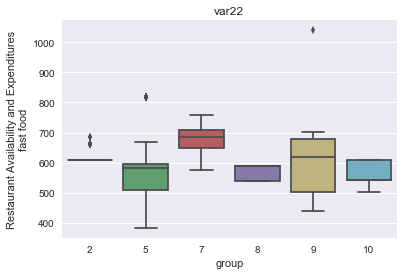

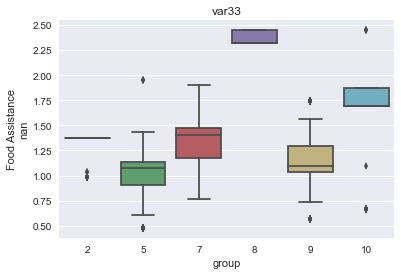

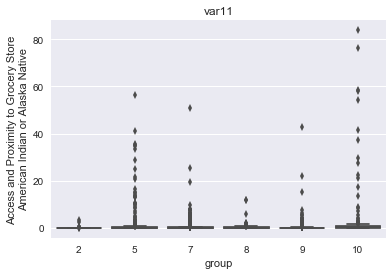

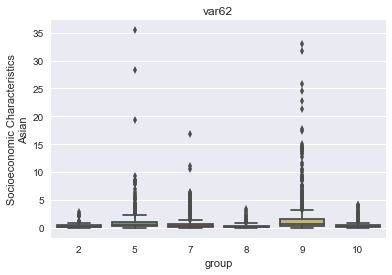

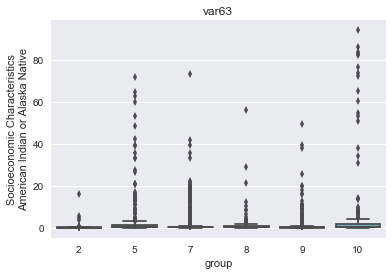

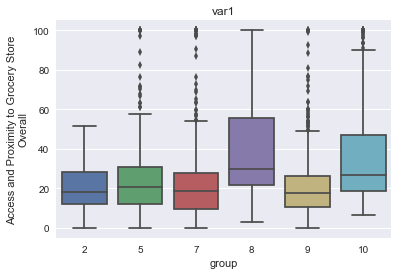

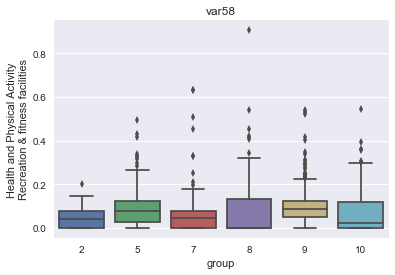

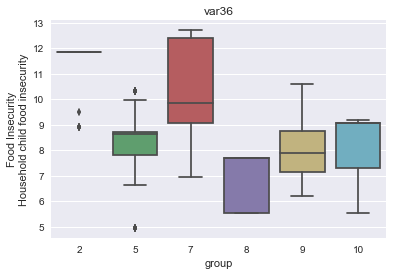

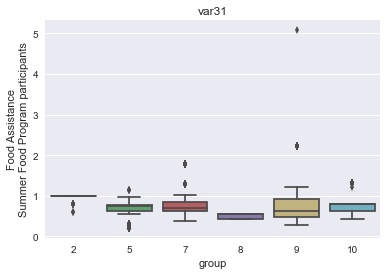

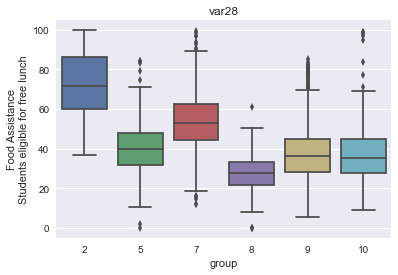

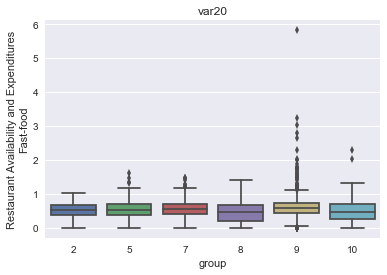

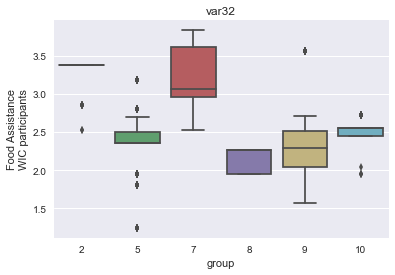

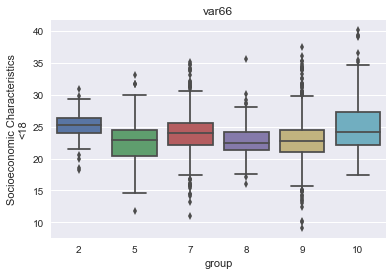

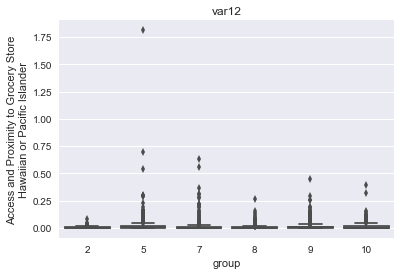

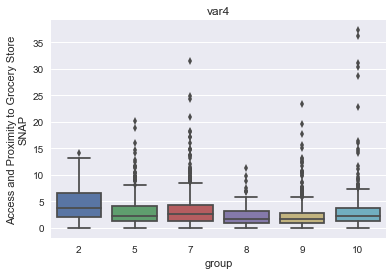

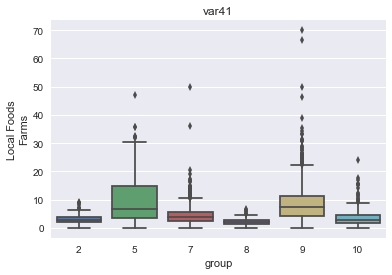

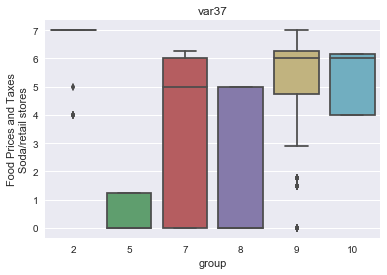

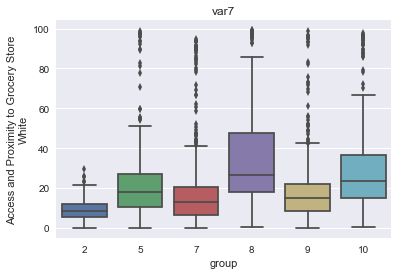

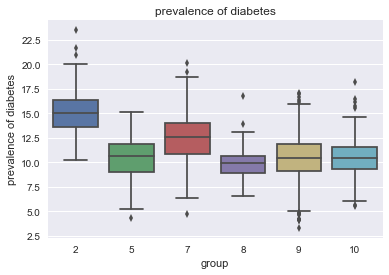

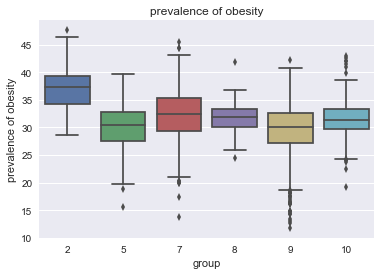

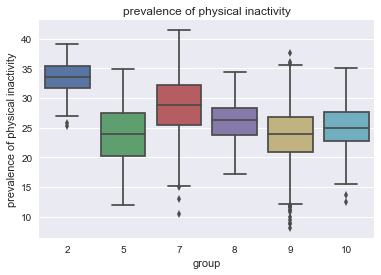

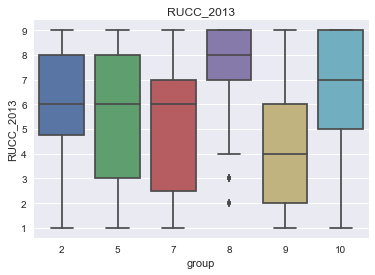

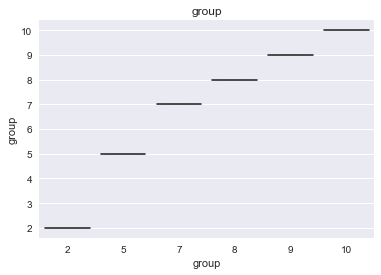

In [359]:
#colors=['b','g','y','r', 'orange','m', 'purple']

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype


features=df.columns
data=df[df['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group')

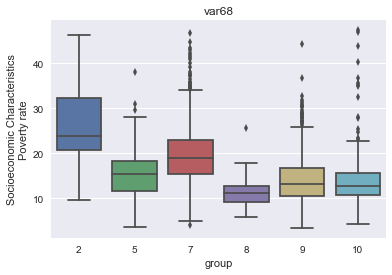

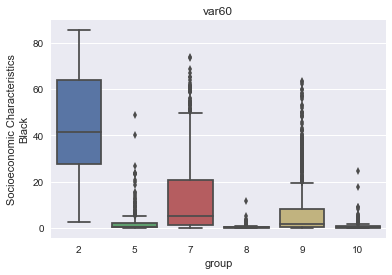

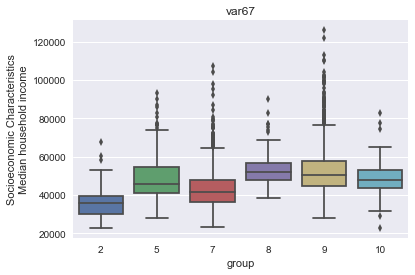

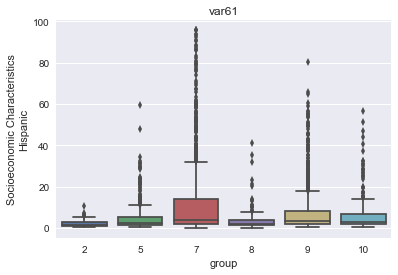

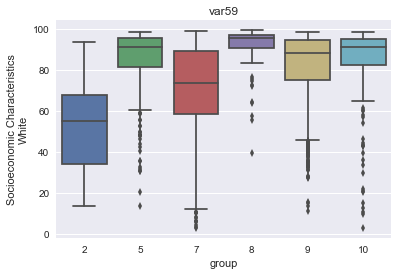

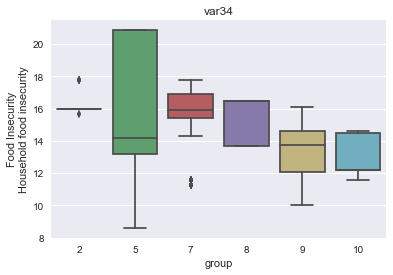

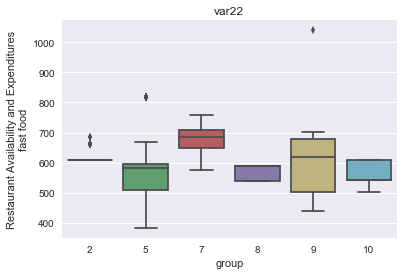

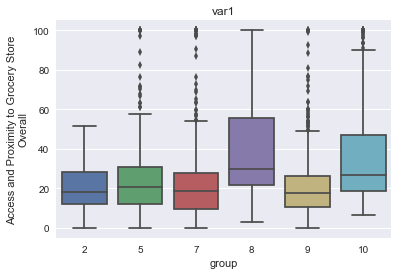

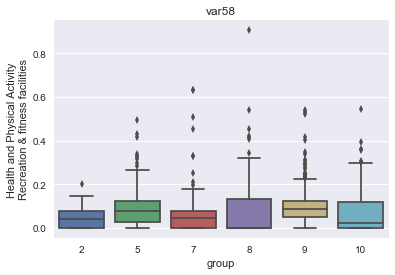

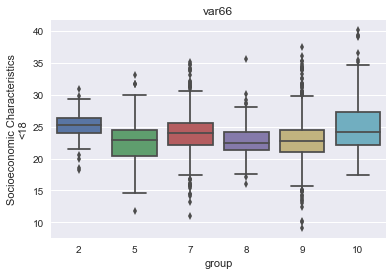

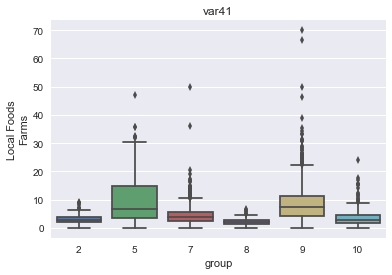

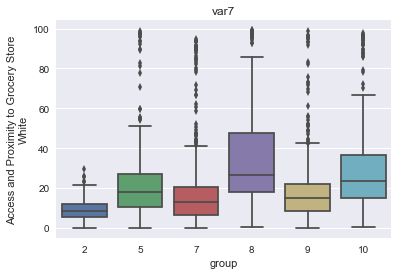

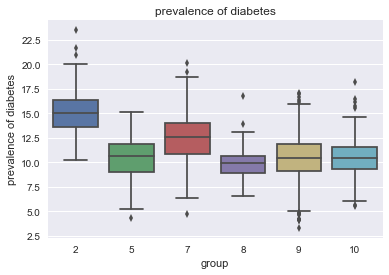

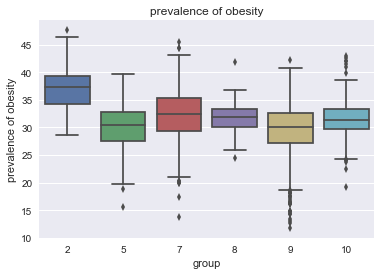

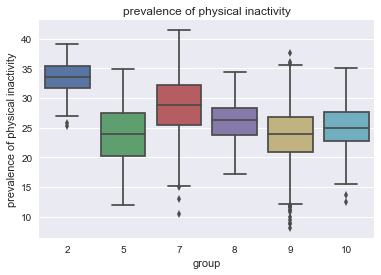

In [360]:
features=['var'+str(i) for i in [68, 60, 67, 61, 59, 34, 22, 1, 58, 66, 41, 7]]
features.extend(['prevalence of diabetes','prevalence of obesity','prevalence of physical inactivity'])
data=df[df['group'].isin(groups_to_plot)]
Box_plot_by_var(features, data, by='group')

In [363]:
race_var_list=list()
for v in var_info_df.index:
    if var_info_df.loc[v]['Category Code']=='SOCIOECONOMIC' and var_info_df.loc[v]['Subcategory Name']=='Race':
        race_var_list.append((var_info_df.loc[v]['Sub_subcategory Name'], v))
print (race_var_list)

[('White', 'var59'), ('Black', 'var60'), ('Hispanic', 'var61'), ('Asian', 'var62'), ('American Indian or Alaska Native', 'var63'), ('Hawaiian or Pacific Islander', 'var64')]


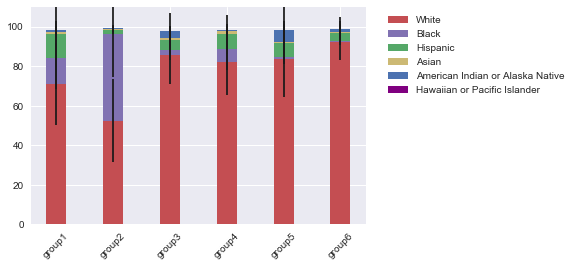

In [382]:
#stacked percentage plot with standard deviation

import numpy as np
import matplotlib.pyplot as plt

whitemeans=np.empty(6)
whitestd=np.empty(6)
blackmeans=np.empty(6)
blackstd=np.empty(6)
asianmeans=np.empty(6)
asianstd=np.empty(6)
hispmeans=np.empty(6)
hispstd=np.empty(6)
Ame_Ind_Alkmeans=np.empty(6)
Ame_Ind_Alkstd=np.empty(6)
Hawa_Islandmeans=np.empty(6)
Hawa_Islandstd=np.empty(6)


for n, group in enumerate(groups_to_plot):
    df_group=df[df['group']==group]
    whitemeans[n]=np.mean(df_group['var59'])
    whitestd[n]=np.std(df_group['var59'])
    
    blackmeans[n]=np.mean(df_group['var60'])
    blackstd[n]=np.std(df_group['var60'])
    
    asianmeans[n]=np.mean(df_group['var62'])
    asianstd[n]=np.std(df_group['var62'])
    
    hispmeans[n]=np.mean(df_group['var61'])
    hispstd[n]=np.std(df_group['var61'])
    
    Ame_Ind_Alkmeans[n]=np.mean(df_group['var63'])
    Ame_Ind_Alkstd[n]=np.std(df_group['var63'])
    
    Hawa_Islandmeans[n]=np.mean(df_group['var64'])
    Hawa_Islandstd[n]=np.std(df_group['var64'])

width = 0.35       # the width of the bars: can also be len(x) sequence

ind = np.arange(6)

p1=plt.bar(ind, whitemeans, width, color='r', yerr=whitestd)
p2=plt.bar(ind, blackmeans, width, color='m', bottom=whitemeans, yerr=blackstd)
p3=plt.bar(ind, hispmeans, width, color='g', bottom=sum([whitemeans,blackmeans]), yerr=hispstd)
p4=plt.bar(ind, asianmeans, width, color='y', bottom=sum([whitemeans, blackmeans, hispmeans]), yerr=asianstd)
p5=plt.bar(ind, Ame_Ind_Alkmeans, width, color='b', bottom=sum([whitemeans, blackmeans, hispmeans, asianmeans]), yerr=Ame_Ind_Alkstd)
p6=plt.bar(ind, Hawa_Islandmeans, width, color='purple', 
        bottom=np.sum([whitemeans,blackmeans,hispmeans,asianmeans,Ame_Ind_Alkmeans]), yerr=Hawa_Islandstd)

plt.legend((p1[0], p2[0],p3[0], p4[0],p5[0], p6[0]), ('White', 'Black', 
                                                      'Hispanic', 'Asian','American Indian or Alaska Native', 
                                                      'Hawaiian or Pacific Islander'), bbox_to_anchor=(1.04,1))
plt.xticks(range(6), ['group'+str(i) for i in range(1,7)], rotation=45)
plt.ylim(0, 110)
plt.show()

In [383]:
age_var_list=list()
for v in var_info_df.index:
    if var_info_df.loc[v]['Category Code']=='SOCIOECONOMIC' and var_info_df.loc[v]['Subcategory Name']=='Age':
        age_var_list.append((var_info_df.loc[v]['Sub_subcategory Name'], v))
print (age_var_list)

[('>=65', 'var65'), ('<18', 'var66')]


C:\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


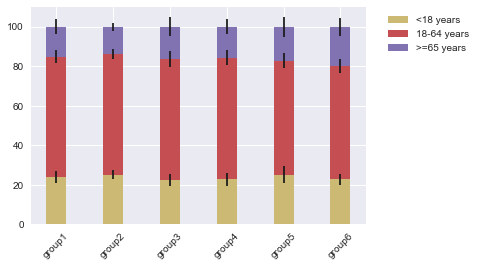

In [385]:
#stacked percentage plot with standard deviation

import numpy as np
import matplotlib.pyplot as plt

under_18_means=np.empty(6)
under_18_std=np.empty(6)
fr18to65_means=np.empty(6)
fr18to65_std=np.empty(6)
above_65_means=np.empty(6)
above_65_std=np.empty(6)


for n, group in enumerate(groups_to_plot):
    df_group=df[df['group']==group]
    df_group['adult']=100-df_group['var65']-df_group['var66']
    
    under_18_means[n]=np.mean(df_group['var66'])
    under_18_std[n]=np.std(df_group['var66'])
    
    fr18to65_means[n]=np.mean(df_group['adult'])
    fr18to65_std[n]=np.std(df_group['adult'])
    
    above_65_means[n]=np.mean(df_group['var65'])
    above_65_std[n]=np.std(df_group['var65'])

width = 0.35       # the width of the bars: can also be len(x) sequence

ind = np.arange(6)

p1=plt.bar(ind, under_18_means, width, color='y', yerr=under_18_std)
p2=plt.bar(ind, fr18to65_means, width, color='r', bottom=under_18_means, yerr=fr18to65_std)
p3=plt.bar(ind, above_65_means, width, color='m', bottom=sum([under_18_means,fr18to65_means]), yerr=above_65_std)


plt.legend((p1[0], p2[0],p3[0]), ('<18 years', '18-64 years', '>=65 years'), bbox_to_anchor=(1.04,1))
plt.xticks(range(6), ['group'+str(i) for i in range(1,7)], rotation=45)
plt.ylim(0, 110)
plt.show()

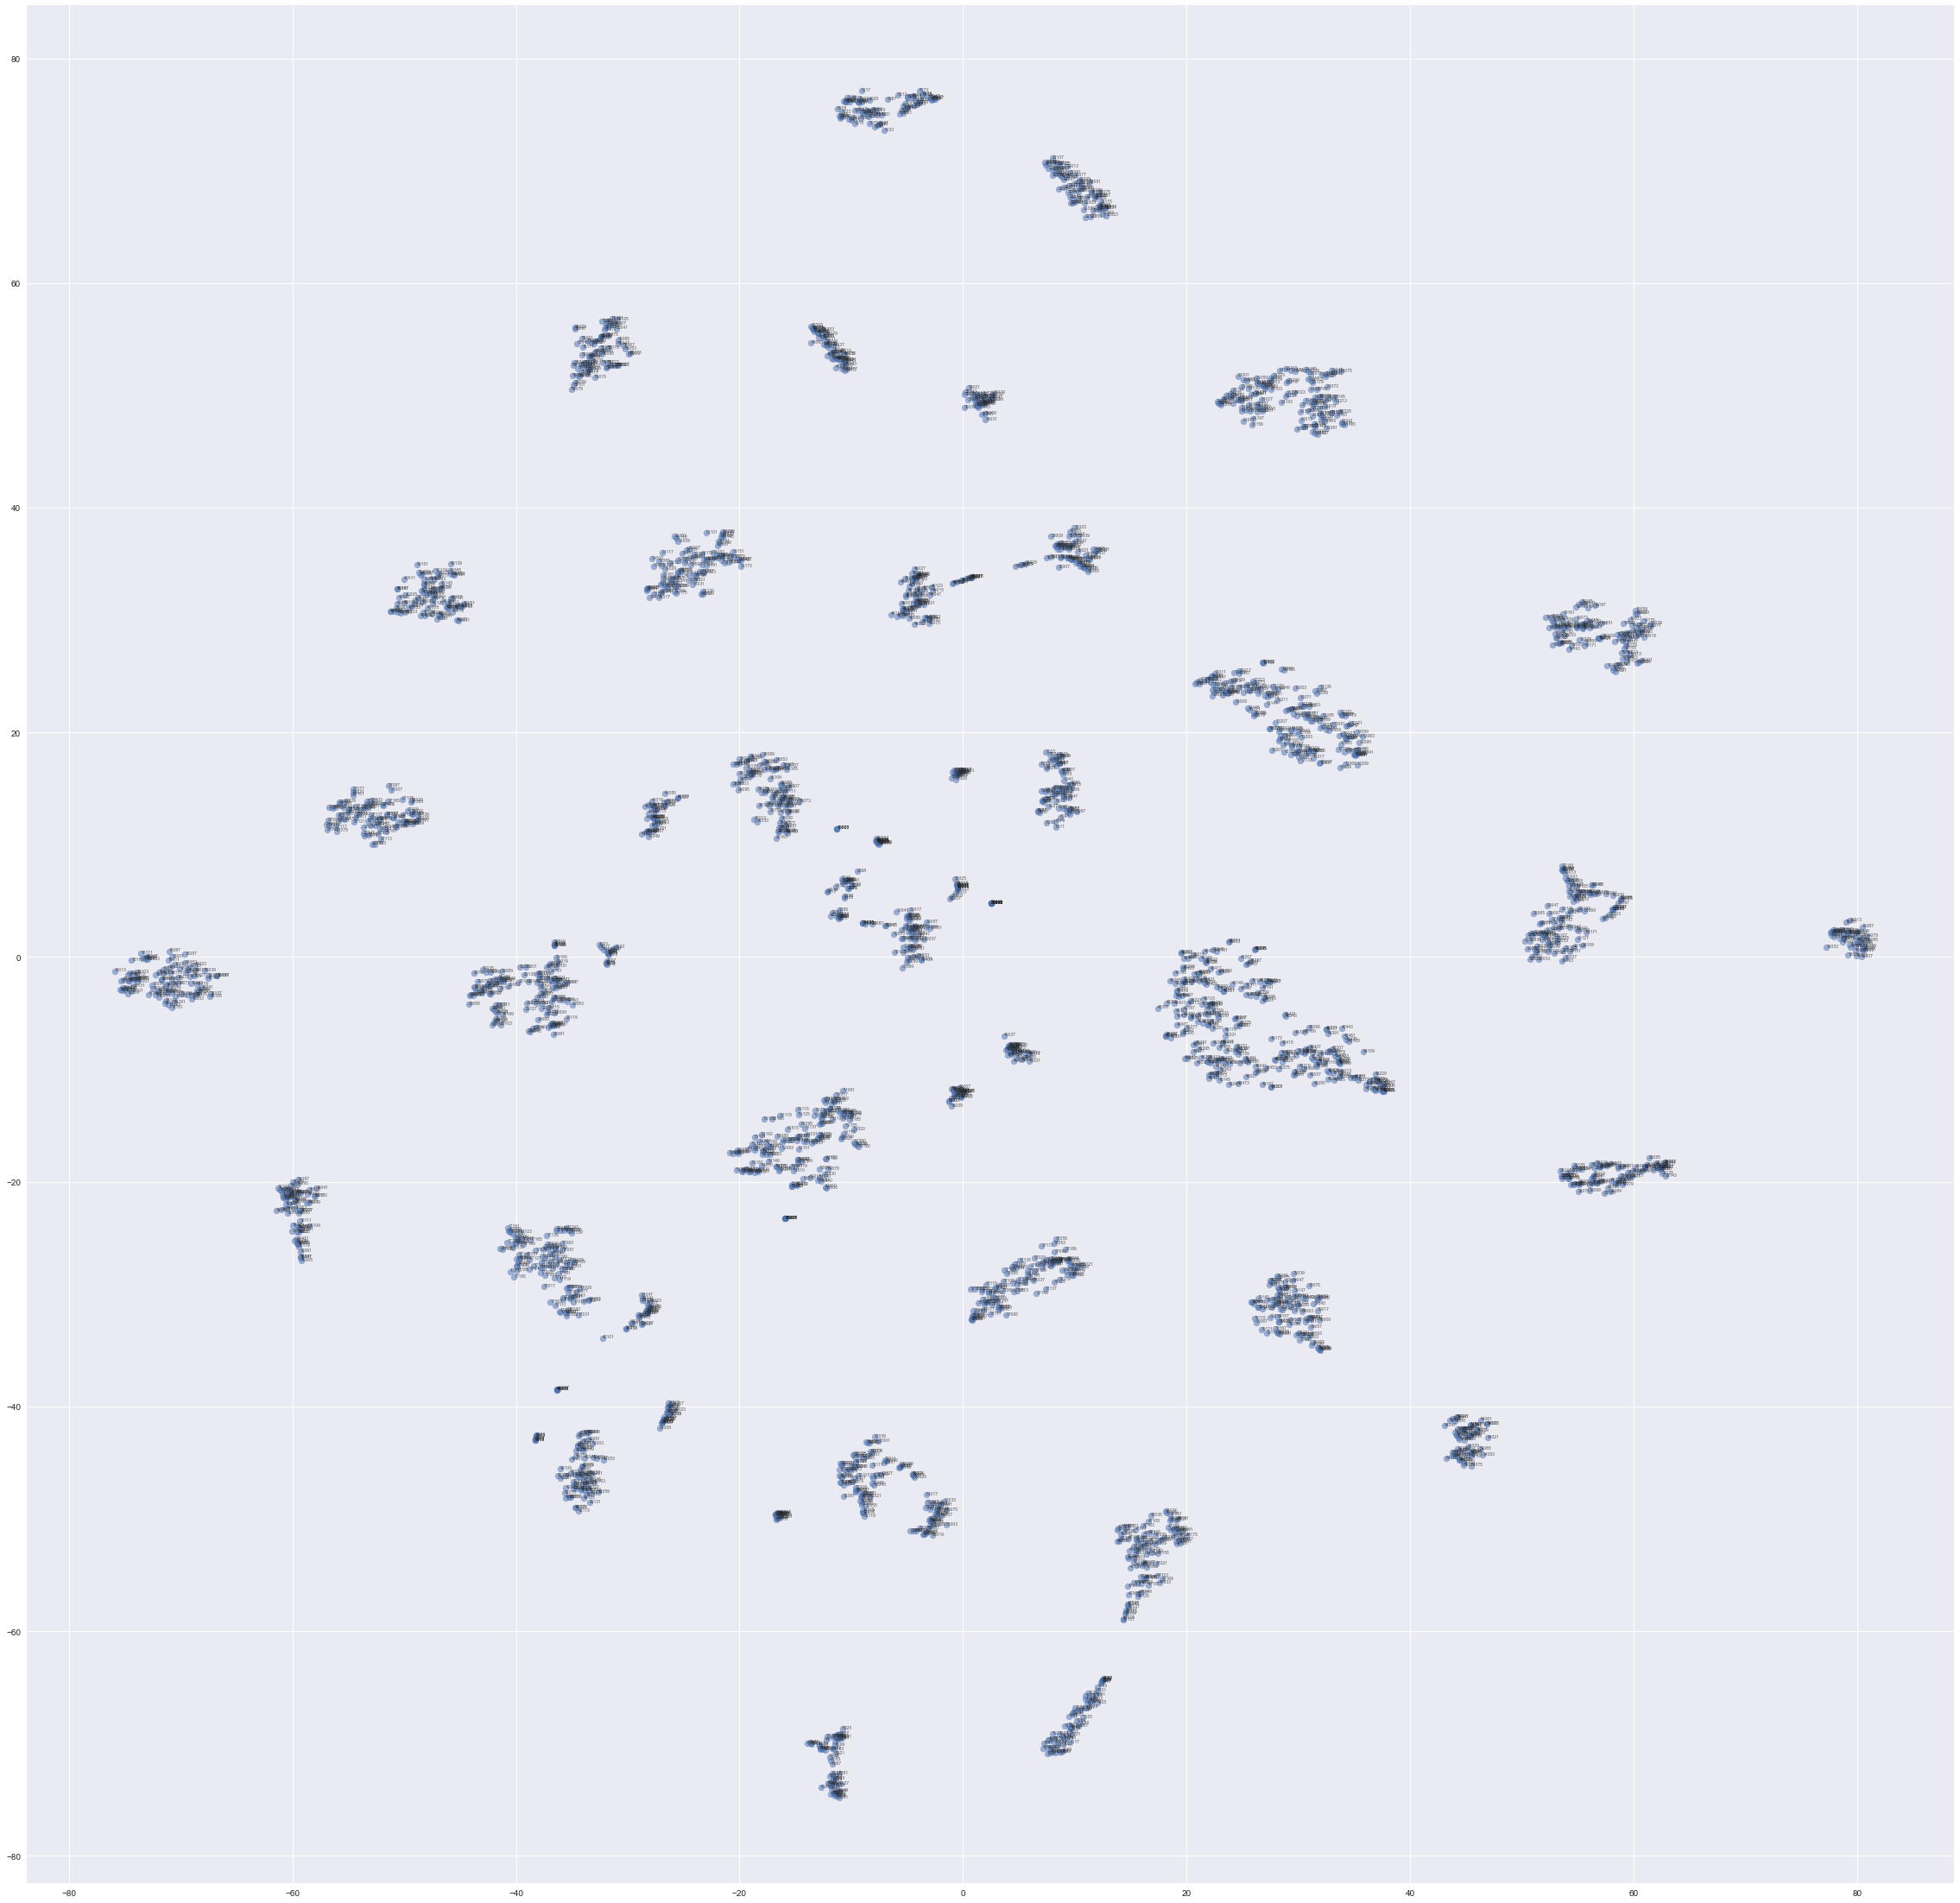

In [361]:
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(normed_df[normed_df.columns.difference(['group'])])

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(40,40))
plt.scatter(xs, ys, alpha=0.5)
# Scatter plot


# Annotate the points
for x, y, fips in zip(xs, ys, normed_df.index):
    plt.annotate(fips, (x, y), fontsize=5, alpha=0.75)
plt.show()


Hierachical clustering of the most diabetes prevalent counties

In [263]:
np.array(df['prevalence of diabetes'])

array([ 13. ,  10.4,  18.4, ...,   9. ,  12. ,  10. ])

In [296]:
top_prev_db=np.percentile(df['prevalence of diabetes'].dropna(), 80)

In [295]:
print (top_prev_db)

12.9


In [278]:
df_sub=df[df['prevalence of diabetes']>13.3]

In [279]:
df_sub_drop=df_sub[df_sub.columns.difference(['Region', 'Division','State', 'County', 'RUCC_2013', 'Adult_db', 'Adult_ob'])]

In [280]:
df_sub_drop=df_sub_drop.dropna(axis=1)

In [281]:
df_sub_drop.shape

(621, 42)

In [282]:
normed_data_sub=preprocessing.scale(df_sub_drop)
normed_df_sub=pd.DataFrame(normed_data_sub, index=df_sub_drop.index, columns=df_sub_drop.columns)

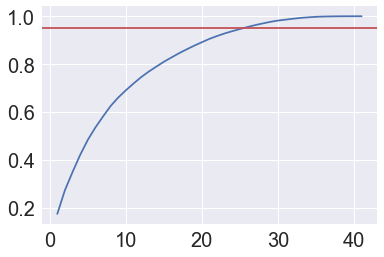

In [283]:
explained_var=list()
for d in range(1,len(normed_df_sub.columns)):
    pca = PCA(n_components=d)
    pca.fit(normed_df_sub)
    explained_var.append(sum(pca.explained_variance_ratio_))
    
plt.plot(range(1,len(normed_df_sub.columns)), explained_var)
plt.axhline(y=0.95, color='r')
plt.show()

In [284]:
#95% of variance can be explained by 25 components out of total 42 variables
pca = PCA(n_components=25)
pca.fit(normed_df_sub)
data_sub_transformed=pca.transform(normed_df_sub)
df_sub_transformed=pd.DataFrame(data_sub_transformed, index=normed_df_sub.index)

In [285]:
X=data_sub_transformed
distance_way= ['ward', 'single', 'average', 'weighted', 'centroid', 'median']

for m in distance_way:
    Z = linkage(X, m)
    c, coph_dists = cophenet(Z, pdist(X))
    print (m, c)

ward 0.479151165849
single 0.808784766887
average 0.860068986743
weighted 0.778882387109
centroid 0.848816734519
median 0.773669989874


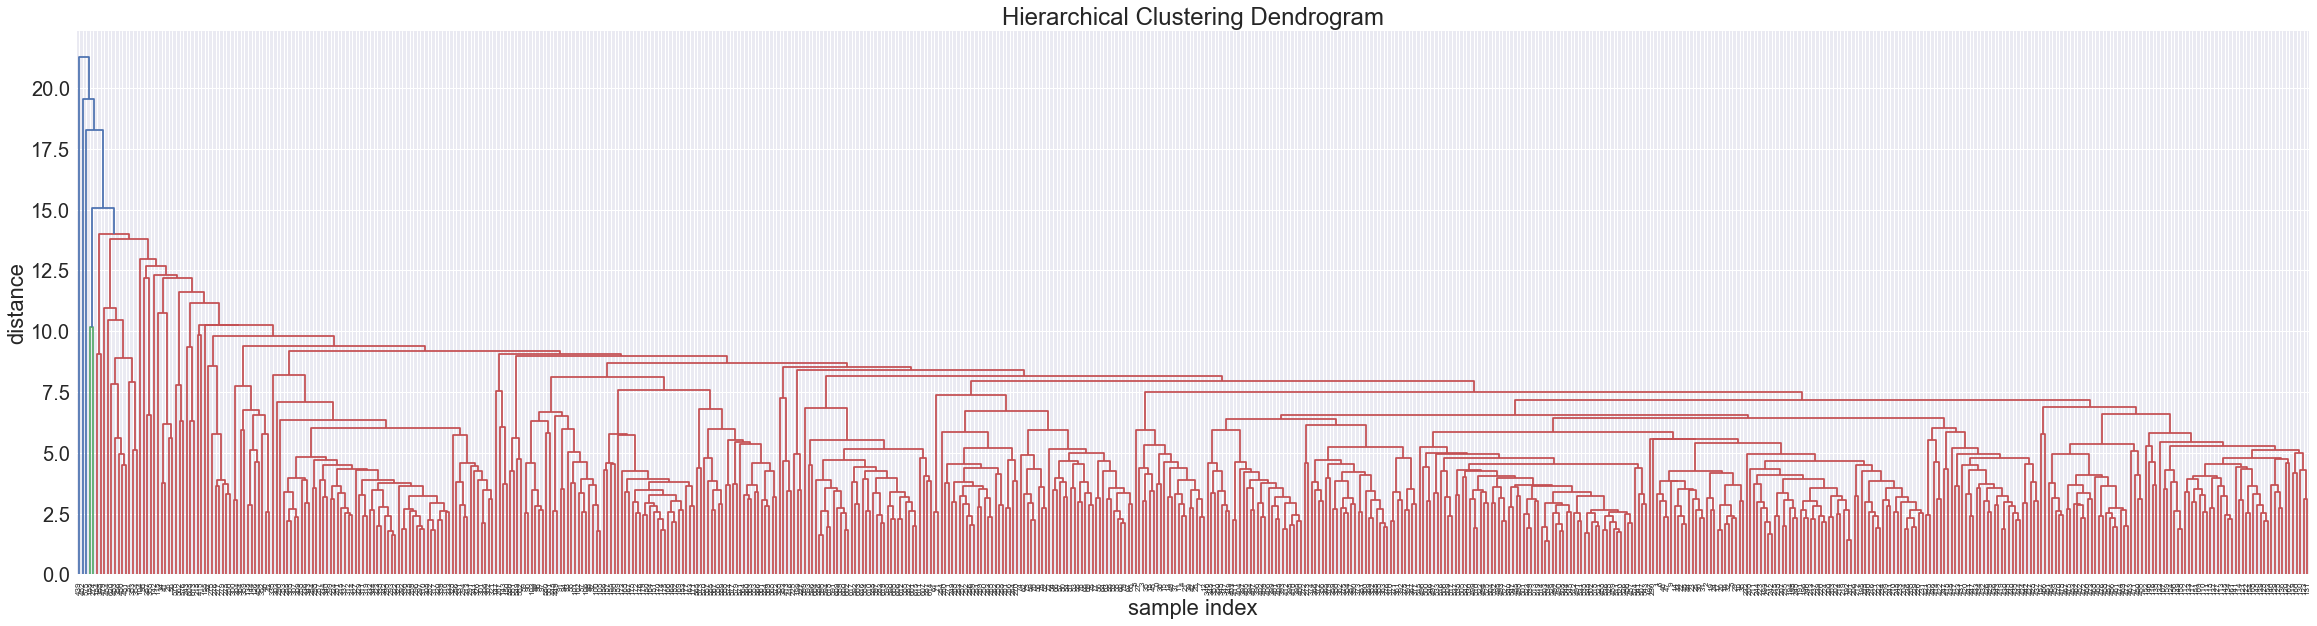

In [286]:
Z = linkage(X, 'average')
plt.figure(figsize=(40, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.show()

In [287]:
for distance in range(5,15):
    labels = fcluster(Z,distance,'distance')
    print (distance, max(Counter(labels).values()), max(labels))

5 60 117
6 141 70
7 232 48
8 383 36
9 501 27
10 585 20
11 588 14
12 594 12
13 604 7
14 616 5


In [288]:
labels = fcluster(Z,8,'distance')

In [289]:
print (Counter(labels))

Counter({30: 383, 21: 61, 26: 49, 29: 36, 25: 22, 20: 11, 18: 6, 5: 5, 11: 4, 23: 4, 27: 4, 24: 4, 6: 3, 28: 3, 13: 3, 9: 2, 14: 2, 19: 1, 10: 1, 33: 1, 12: 1, 32: 1, 31: 1, 3: 1, 1: 1, 16: 1, 15: 1, 2: 1, 22: 1, 4: 1, 17: 1, 36: 1, 8: 1, 35: 1, 7: 1, 34: 1})


In [290]:
groups_to_plot=[l for l in Counter(labels).keys() if Counter(labels)[l]>20]

In [291]:
df_sub_drop['group']=labels

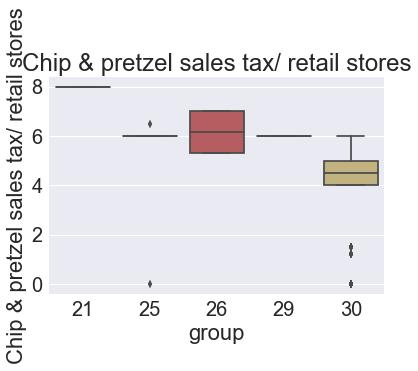

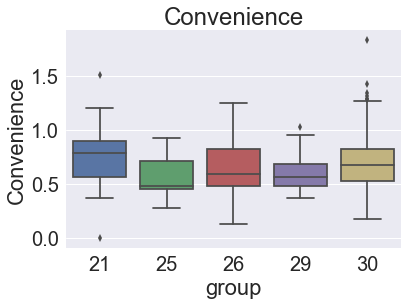

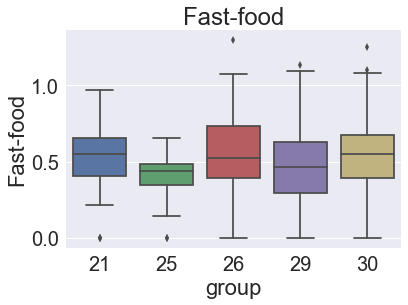

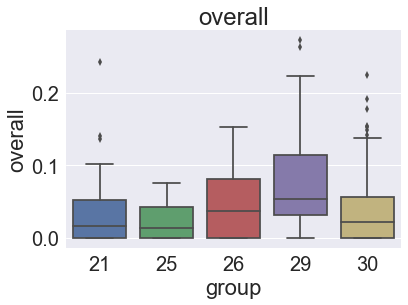

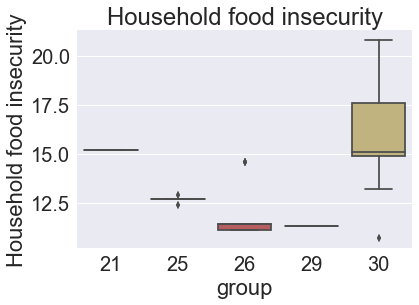

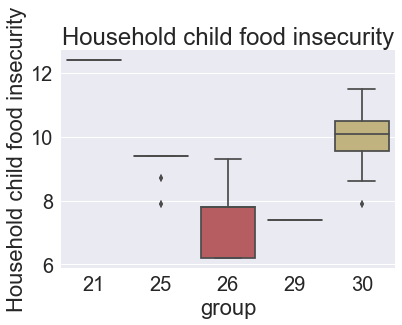

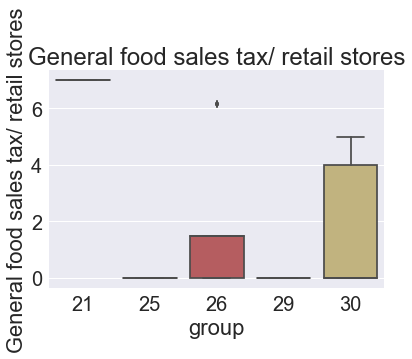

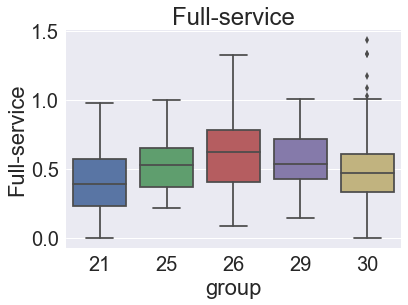

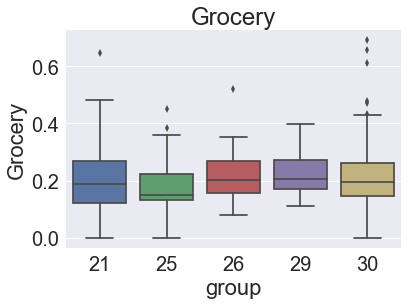

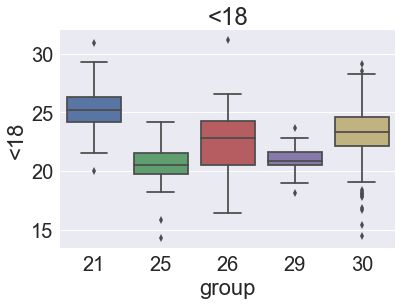

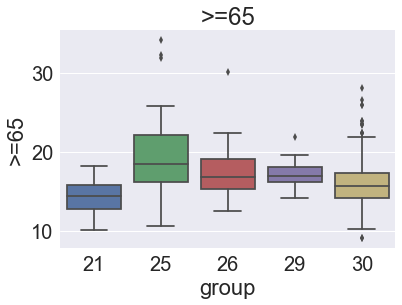

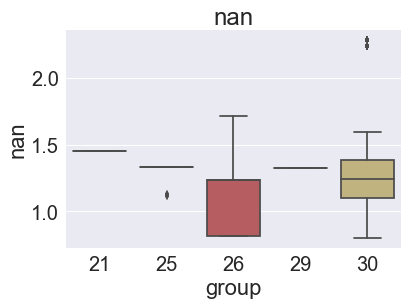

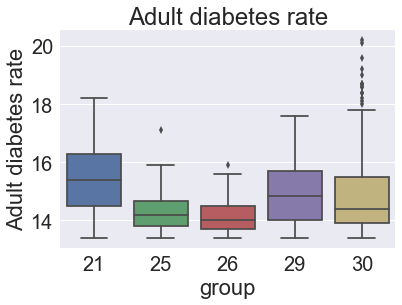

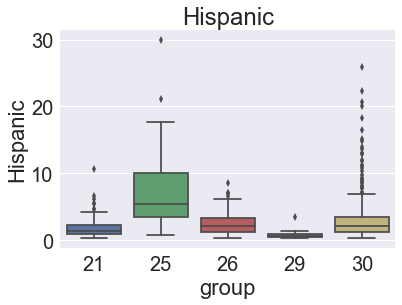

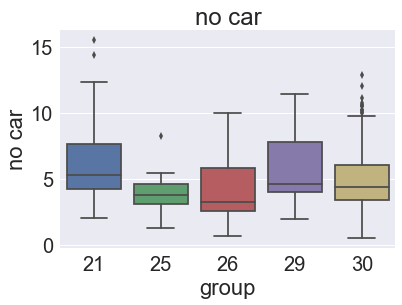

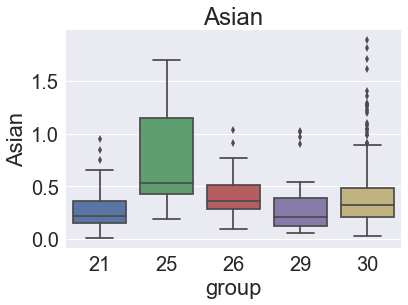

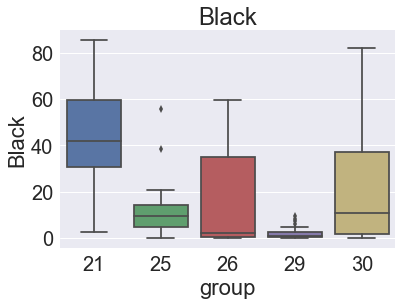

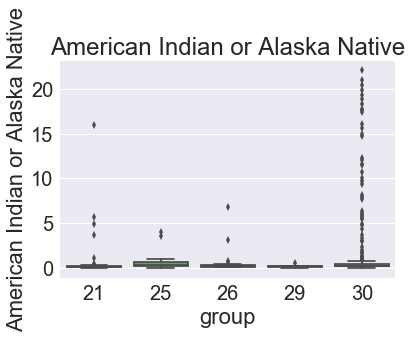

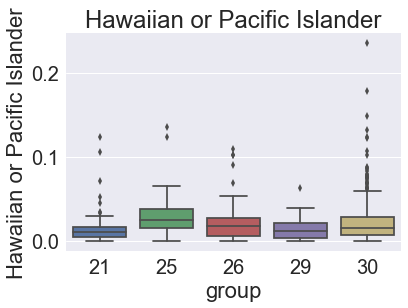

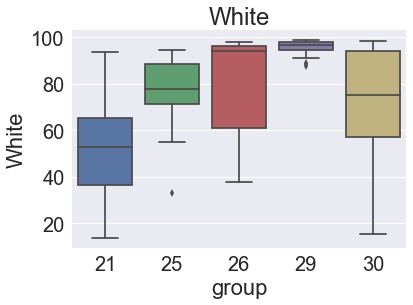

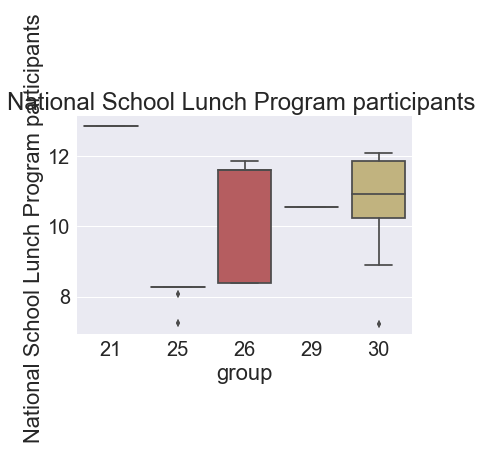

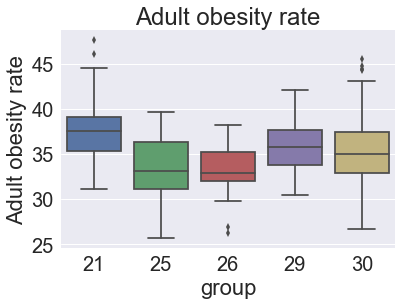

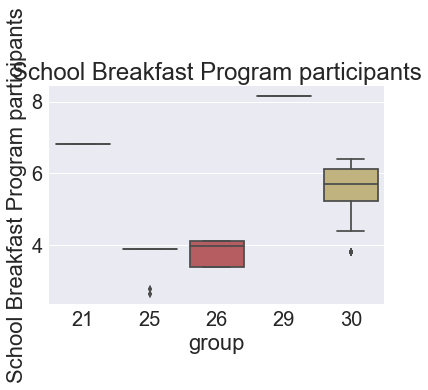

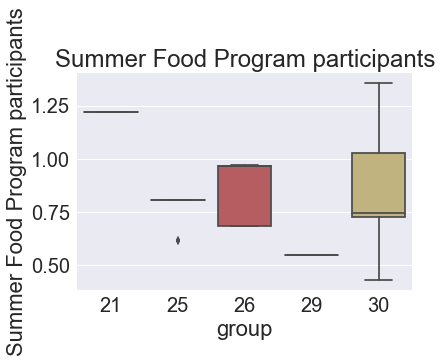

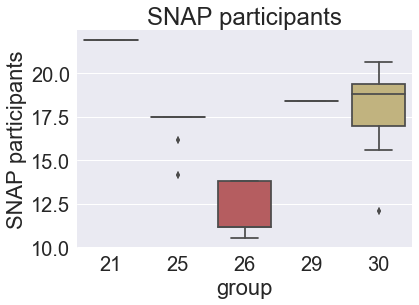

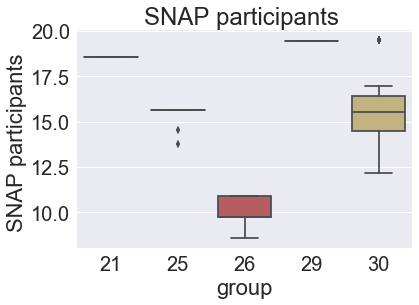

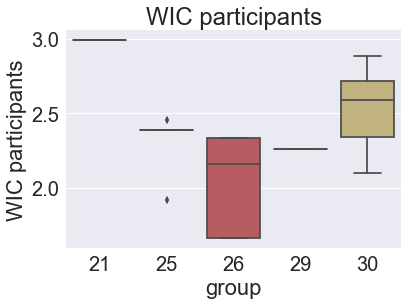

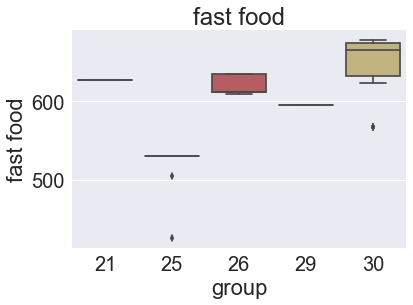

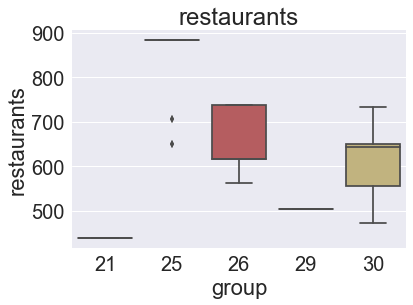

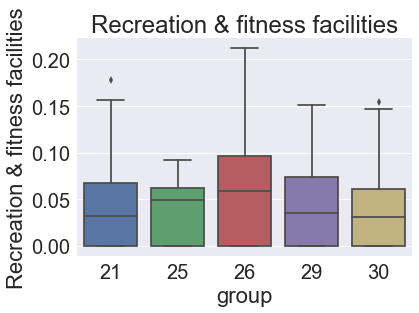

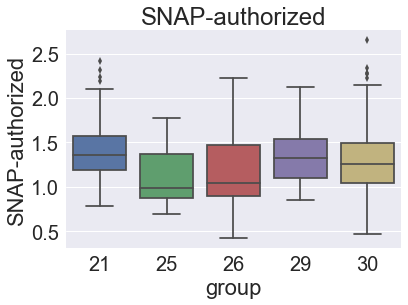

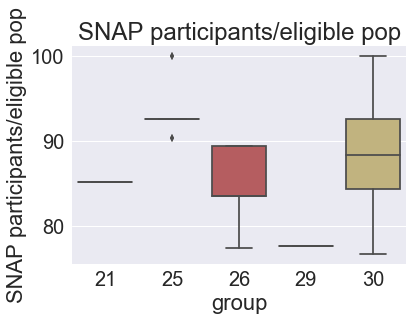

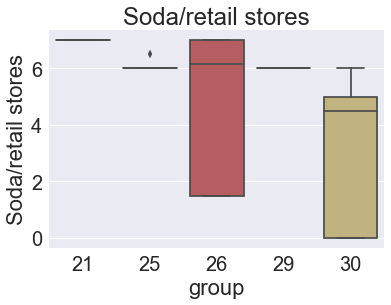

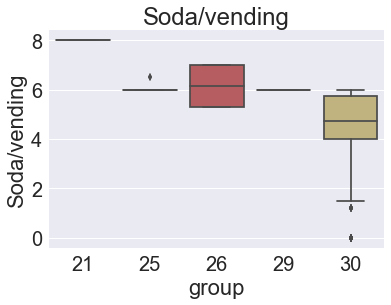

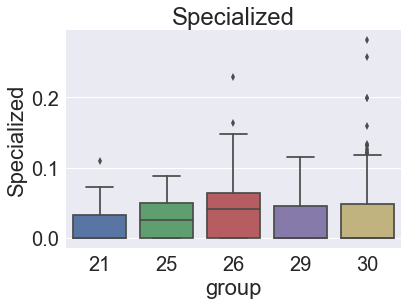

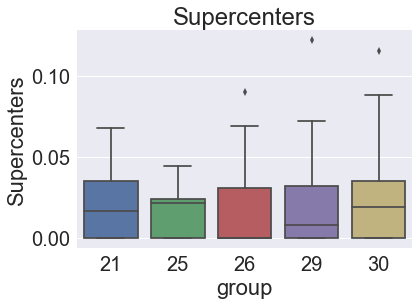

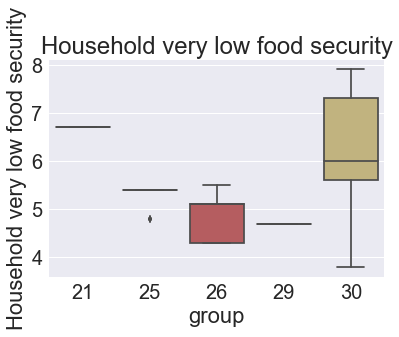

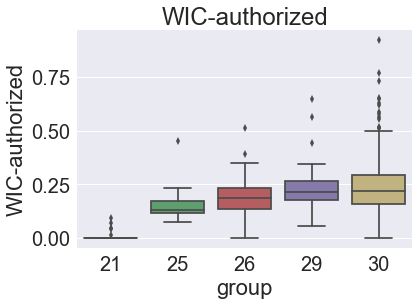

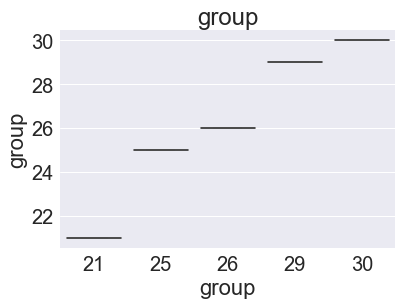

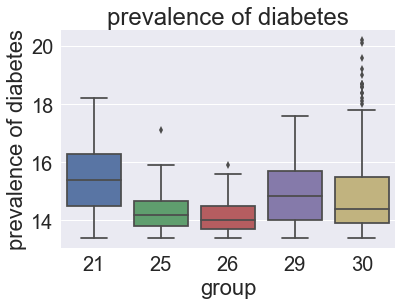

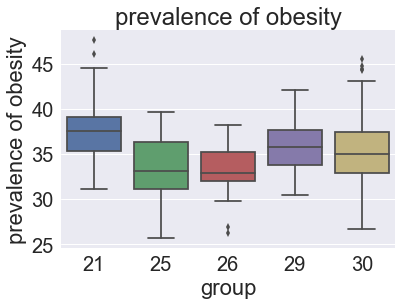

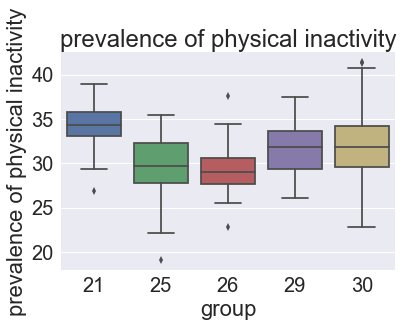

In [293]:
for c in df_sub_drop.columns:
    if is_numeric_dtype(df_sub_drop[c]):
        plt.figure()
        sns.boxplot(x='group', y=c, data=df_sub_drop[df_sub_drop['group'].isin(groups_to_plot)])
        if c in var_info_dict['Sub_subcategory Name'].keys():
            plt.title(var_info_dict['Sub_subcategory Name'][c])
            plt.ylabel(var_info_dict['Sub_subcategory Name'][c])
            
        else:
            plt.title(c) 
            plt.ylabel(c)
        
        plt.legend()
        plt.show()

Hierachical clustering of the most obesity prevalent counties

In [297]:
top_prev_ob=np.percentile(df['prevalence of obesity'].dropna(), 80)

In [302]:
df_sub_2=df[df['prevalence of obesity']>top_prev_ob]

In [303]:
df_sub_drop_2=df_sub_2[df_sub_2.columns.difference(['Region', 'Division','State', 'County', 'RUCC_2013', 'Adult_db', 'Adult_ob'])]

In [304]:
df_sub_drop_2=df_sub_drop_2.dropna(axis=1)

In [305]:
df_sub_drop_2.shape

(616, 42)

In [306]:
normed_data_sub_2=preprocessing.scale(df_sub_drop_2)
normed_df_sub_2=pd.DataFrame(normed_data_sub_2, index=df_sub_drop_2.index, columns=df_sub_drop_2.columns)

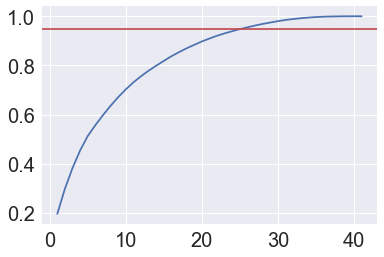

In [307]:
explained_var=list()
for d in range(1,len(normed_df_sub_2.columns)):
    pca = PCA(n_components=d)
    pca.fit(normed_df_sub_2)
    explained_var.append(sum(pca.explained_variance_ratio_))
    
plt.plot(range(1,len(normed_df_sub_2.columns)), explained_var)
plt.axhline(y=0.95, color='r')
plt.show()

In [308]:
#95% of variance can be explained by 25 components out of total 42 variables
pca = PCA(n_components=25)
pca.fit(normed_df_sub_2)
data_sub_2_transformed=pca.transform(normed_df_sub_2)
df_sub_2_transformed=pd.DataFrame(data_sub_2_transformed, index=normed_df_sub_2.index)

In [309]:
X=data_sub_2_transformed
distance_way= ['ward', 'single', 'average', 'weighted', 'centroid', 'median']

for m in distance_way:
    Z = linkage(X, m)
    c, coph_dists = cophenet(Z, pdist(X))
    print (m, c)

ward 0.455630658069
single 0.818551995648
average 0.851666418996
weighted 0.678099053787
centroid 0.843605234423
median 0.714807360049


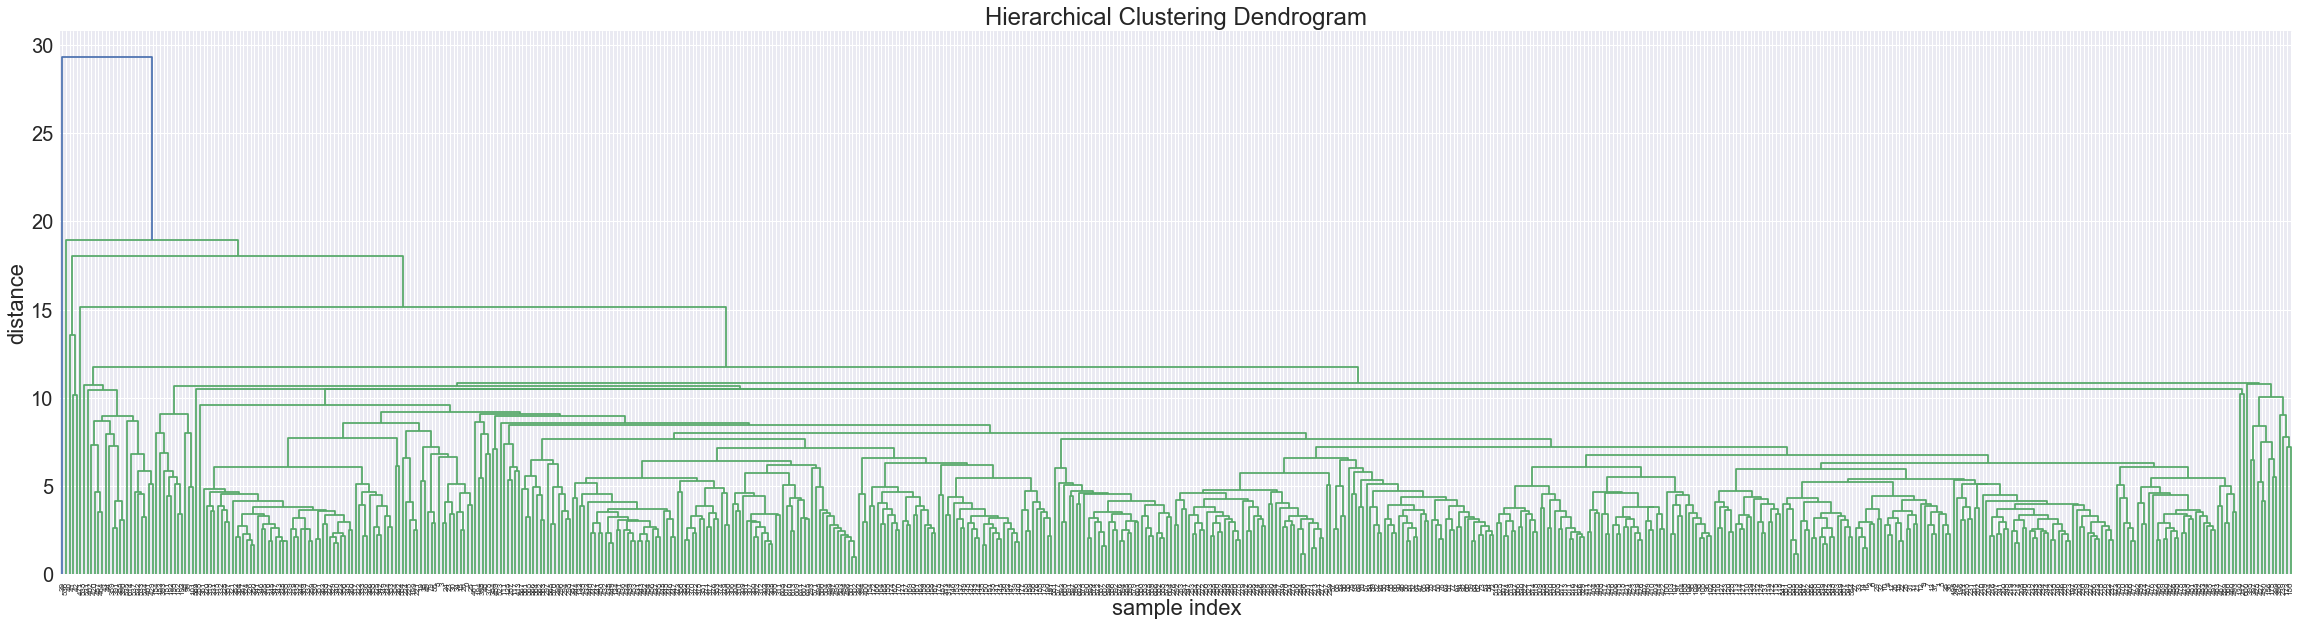

In [310]:
Z = linkage(X, 'average')
plt.figure(figsize=(40, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.show()

In [311]:
for distance in range(5,15):
    labels = fcluster(Z,distance,'distance')
    print (distance, max(Counter(labels).values()), max(labels))

5 42 114
6 111 77
7 205 50
8 327 34
9 482 22
10 563 17
11 590 7
12 610 6
13 610 6
14 610 5


In [312]:
labels = fcluster(Z,8,'distance')

In [313]:
print (Counter(labels))

Counter({21: 327, 20: 147, 13: 55, 15: 15, 10: 8, 6: 7, 5: 6, 28: 6, 19: 5, 14: 5, 16: 4, 4: 4, 29: 3, 11: 2, 18: 2, 27: 2, 34: 1, 3: 1, 1: 1, 2: 1, 12: 1, 24: 1, 25: 1, 23: 1, 30: 1, 17: 1, 32: 1, 22: 1, 8: 1, 7: 1, 33: 1, 9: 1, 26: 1, 31: 1})


In [314]:
groups_to_plot=[l for l in Counter(labels).keys() if Counter(labels)[l]>20]

In [315]:
df_sub_drop_2['group']=labels

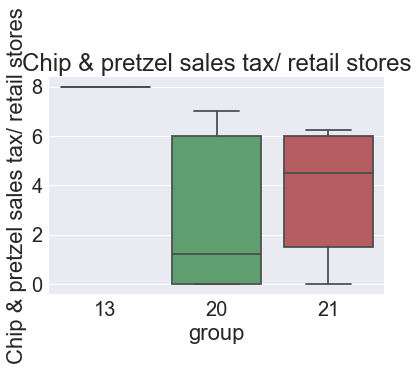

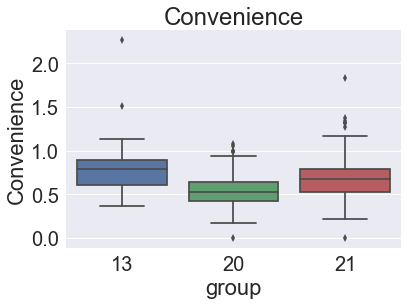

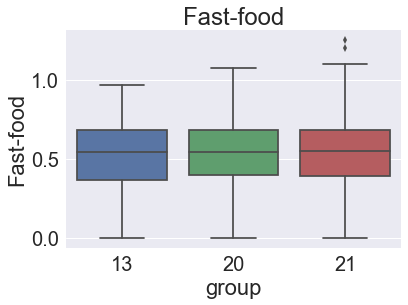

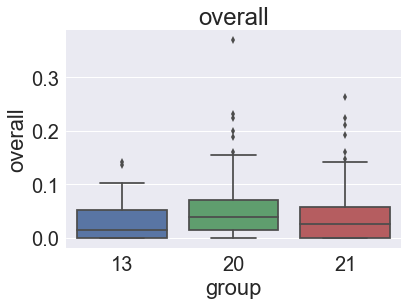

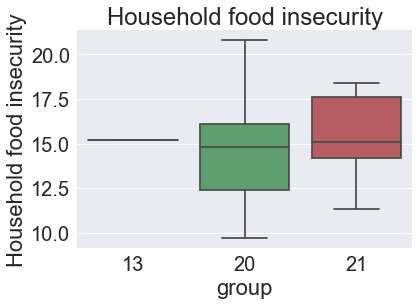

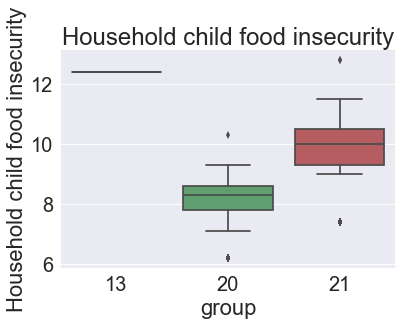

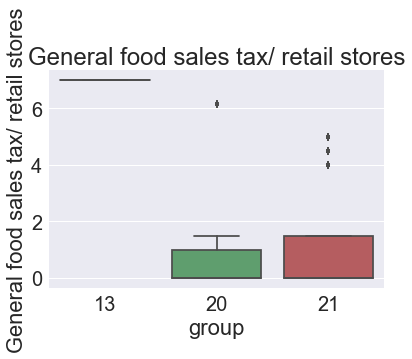

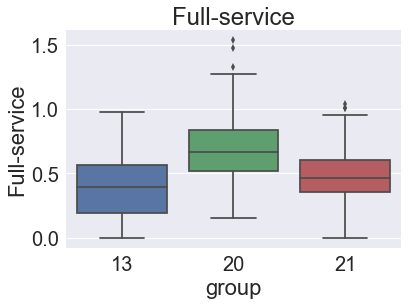

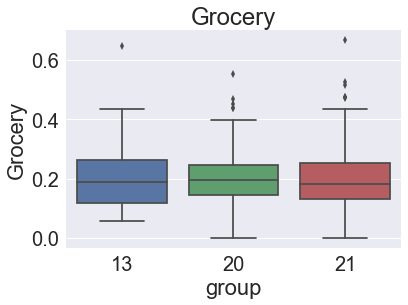

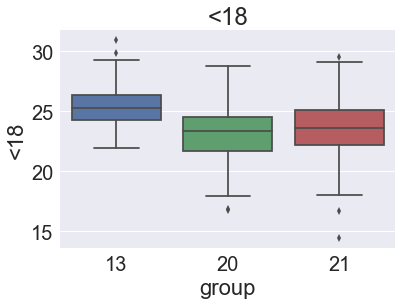

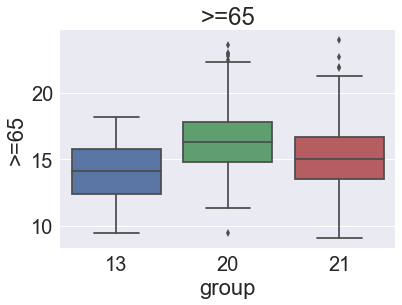

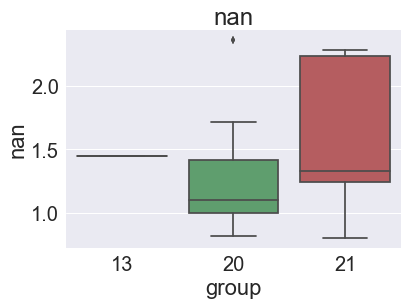

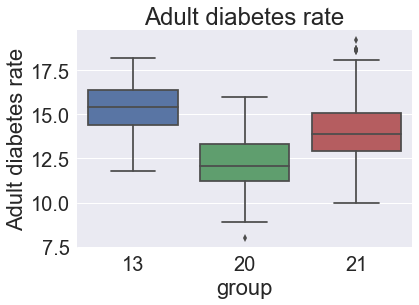

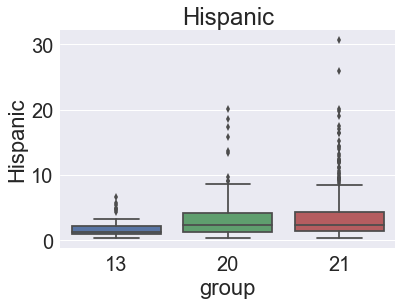

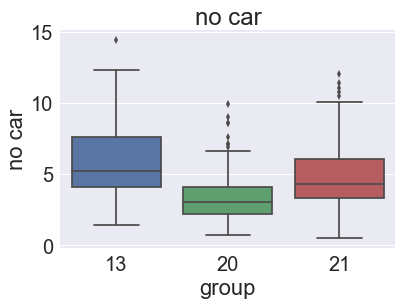

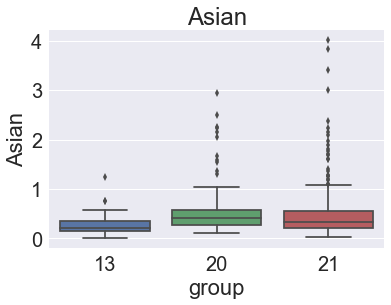

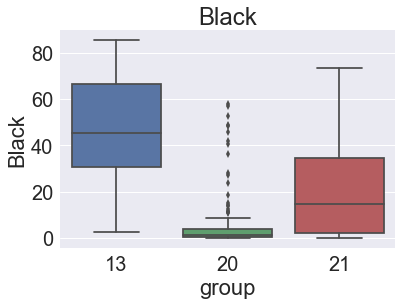

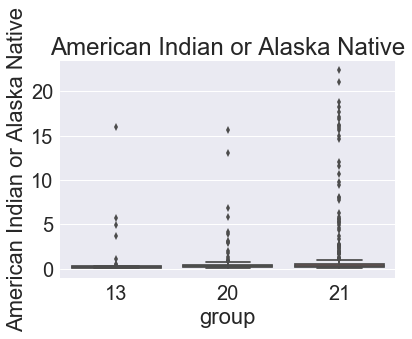

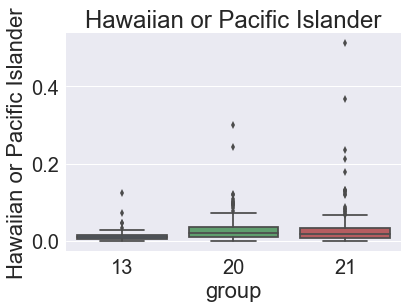

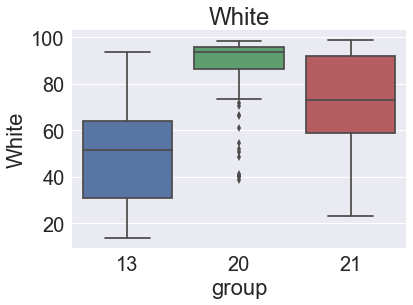

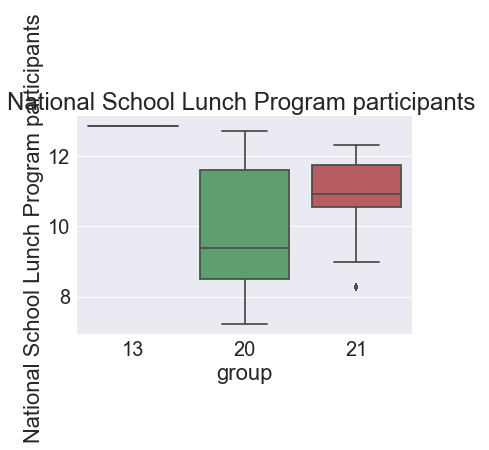

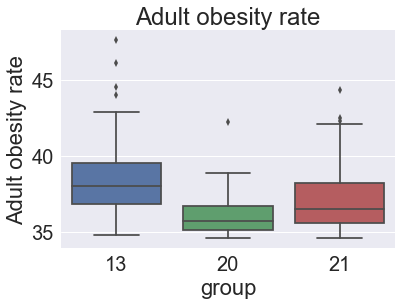

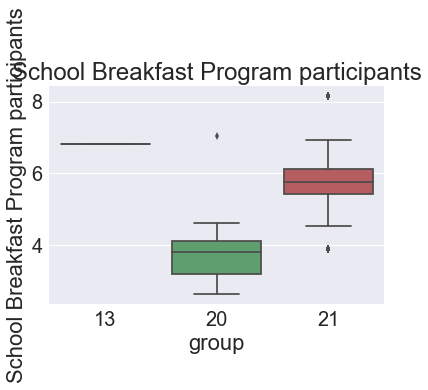

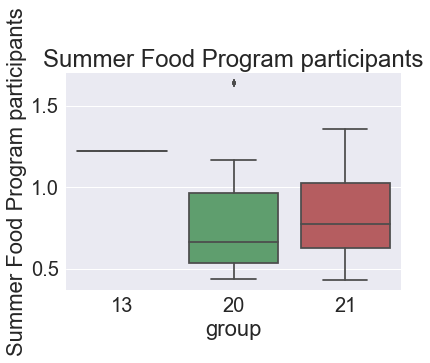

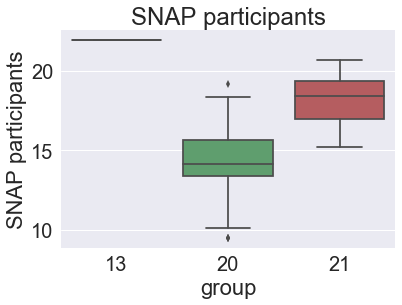

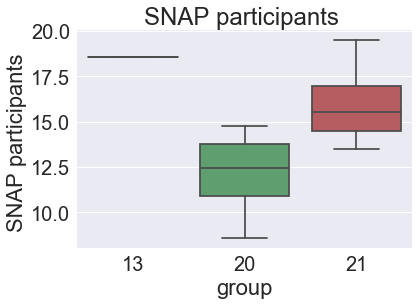

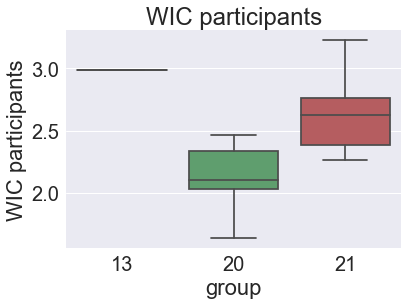

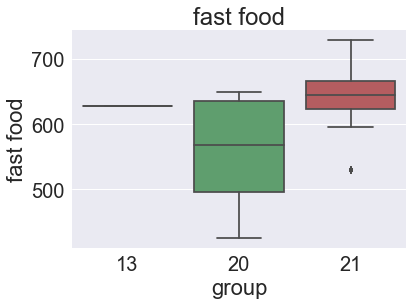

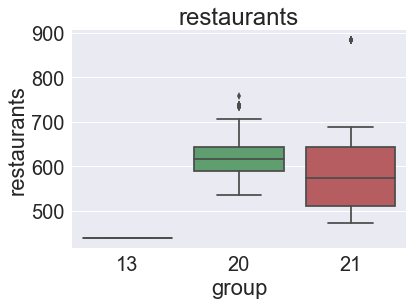

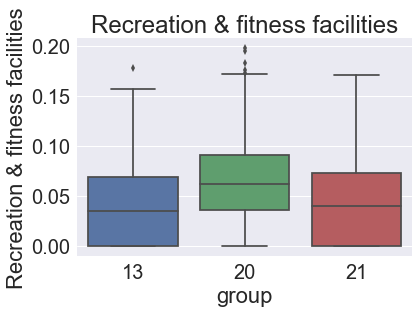

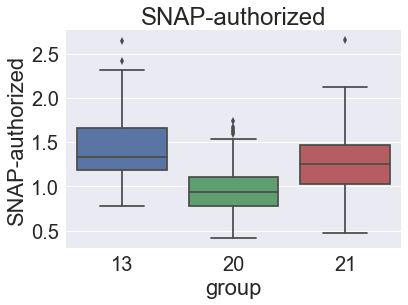

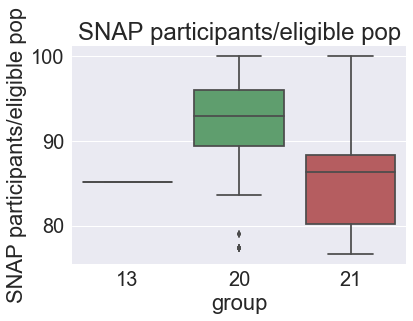

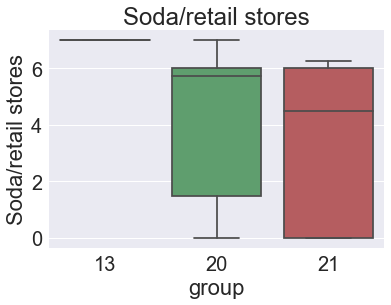

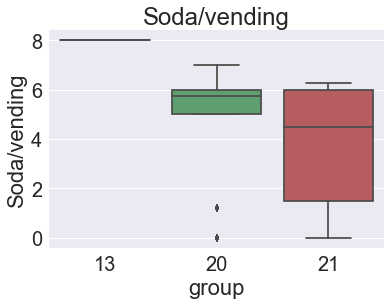

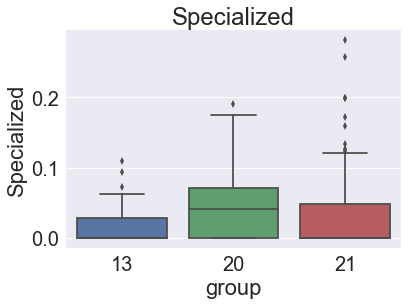

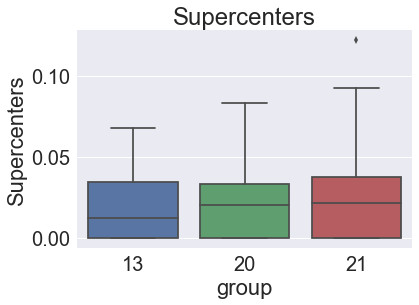

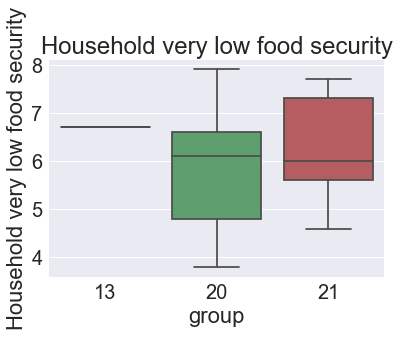

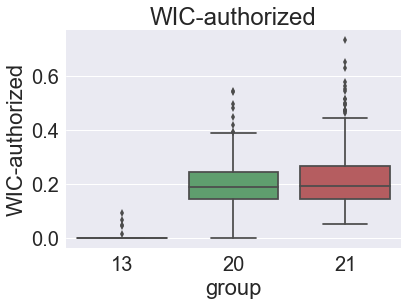

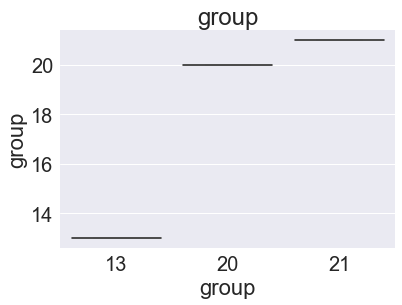

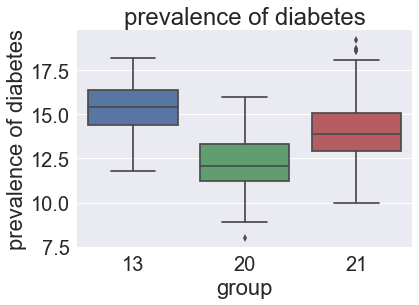

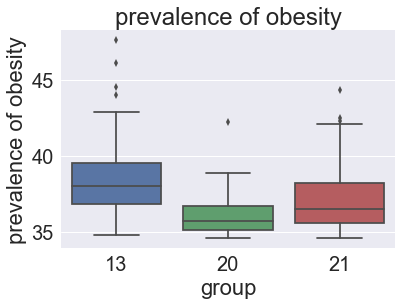

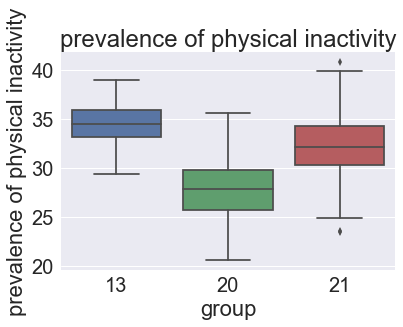

In [316]:
for c in df_sub_drop_2.columns:
    if is_numeric_dtype(df_sub_drop_2[c]):
        plt.figure()
        sns.boxplot(x='group', y=c, data=df_sub_drop_2[df_sub_drop_2['group'].isin(groups_to_plot)])
        if c in var_info_dict['Sub_subcategory Name'].keys():
            plt.title(var_info_dict['Sub_subcategory Name'][c])
            plt.ylabel(var_info_dict['Sub_subcategory Name'][c])
            
        else:
            plt.title(c) 
            plt.ylabel(c)
        
        plt.legend()
        plt.show()